In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove special characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.findall(r'\w+', s)
    return " ".join(s)

In [5]:
def readLangs(lang1, lang2, reverse=False):

    path = "C:/Users/siddp/OneDrive/Desktop/project/encoder-decoder-models"
    lines = open(path + '/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    # lang1 is english and lang2 is french

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 15


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 132157 sentence pairs
Counted words:
fra 20650
eng 12543
['il y a quelque chose qui cloche', 'that doesn t seem right']


In [8]:
print(input_lang.word2count['respecte'])
print(input_lang.word2index['respecte'])
print(output_lang.word2count['respected'])
print(output_lang.word2index['respected'])

34
2341
15
5441


In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Simple Encoder-Decoder Model

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # unsqueeze can be used
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

In [39]:
# Testing encoder model
testing_model = EncoderRNN(input_size=input_lang.n_words, hidden_size=128).to(device)
input = tensorFromSentence(input_lang, random.choice(pairs)[0])
hidden_size = 128
hidden = torch.zeros(1, 1, hidden_size, device=device)
# print(input.get_device())
output, hidden = testing_model(input[0], hidden)
print(output.size())

torch.Size([1, 1, 128])


In [12]:
output[0].size()

torch.Size([1, 128])

In [158]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [159]:
# Testing decoder model
testing_model = DecoderRNN(hidden_size=128, output_size=output_lang.n_words).to(device)
input = tensorFromSentence(output_lang, random.choice(pairs)[1])
# print(input.get_device())
hidden_size=128
hidden = torch.zeros(1, 1, hidden_size, device=device)
output, hidden = testing_model(input[0], hidden)
print(output.size())

torch.Size([1, 12543])


In [160]:
print(output.argmax(1))

tensor([7064], device='cuda:0')


In [161]:
teacher_forcing_ratio = 0.5

In [162]:
# In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context 
# from the entire sequence. This context vector is used as the initial hidden state of the decoder.

In [163]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    # length of input sentence
    target_length = target_tensor.size(0)
    # length of target sentence for training

    loss = 0
    hidden_size = 128
    encoder_hidden = torch.zeros(1, 1, hidden_size, device=device)

    for ei in range(input_length):
        # word by word training in GRU
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Initialized by encoder hidden state, not random initialization.
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(decoder_output.argmax(1), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # topv, topi = decoder_output.topk(1)
            best_guess = decoder_output.argmax(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = best_guess

            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(best_guess, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [164]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"iteration: {iter} and loss: {print_loss_avg}")                             

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(plot_losses)

In [165]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

iteration: 1000 and loss: 4.122932302121956
iteration: 2000 and loss: 4.100129234905553
iteration: 3000 and loss: 4.071954886472316
iteration: 4000 and loss: 4.023332756273478
iteration: 5000 and loss: 3.996266427733541
iteration: 6000 and loss: 3.9900842699854167
iteration: 7000 and loss: 3.9633900327632046
iteration: 8000 and loss: 3.884419621428431
iteration: 9000 and loss: 3.9185299326804706
iteration: 10000 and loss: 3.8689347274697194
iteration: 11000 and loss: 3.815499222018292
iteration: 12000 and loss: 3.8902748845860367
iteration: 13000 and loss: 3.7833620184671704
iteration: 14000 and loss: 3.777705871080399
iteration: 15000 and loss: 3.84167296803537
iteration: 16000 and loss: 3.7141548505745727
iteration: 17000 and loss: 3.719420674402239
iteration: 18000 and loss: 3.6921194569437565
iteration: 19000 and loss: 3.6384075082132155
iteration: 20000 and loss: 3.718917219188978
iteration: 21000 and loss: 3.633888830948248
iteration: 22000 and loss: 3.6718180764640787
iteration:

<Figure size 640x480 with 0 Axes>

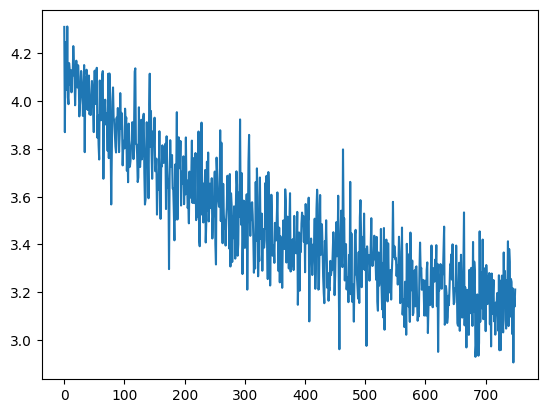

In [180]:
print_every=1000
plot_every=100
learning_rate=0.01
n_iters=75000

trainIters(encoder1, decoder1, n_iters=n_iters, plot_every=plot_every, print_every=print_every)

In [181]:
def get_translation(encoder, decoder, sentence, max_length=MAX_LENGTH):
    print(f"Input sentence is: {sentence}")
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        hidden_size = 128
        encoder_hidden = torch.zeros(1, 1, hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best_guess = decoder_output.argmax(1)
            if best_guess.item() == 1:# EOS_token
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[best_guess.item()])

            decoder_input = best_guess

        return decoded_words

In [182]:
sen = "Il faut que tu reviennes"
# We need you back.	Il faut que tu reviennes
print(get_translation(encoder1, decoder1, sen.lower()))

Input sentence is: il faut que tu reviennes
['you', 'need', 'to', 'do', '<EOS>']


In [183]:
# Saving the models
# https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

path = "C:/Users/siddp/OneDrive/Desktop/project/encoder-decoder-models/model"
torch.save(encoder1.state_dict(), path + "/encoder_simple.pth")
torch.save(decoder1.state_dict(), path + "/decoder_simple.pth")

In [ ]:
# # hidden_size = 128
# # encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# # decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# model_encoder = EncoderRNN(input_lang.n_words, hidden_size)
# model_encoder.load_state_dict(torch.load(path + "/encoder_simple.pth"))
# model_encoder.eval()

# model_decoder = DecoderRNN(hidden_size, output_lang.n_words)
# model_decoder.load_state_dict(torch.load(path + "/decoder_simple.pth"))
# model_decoder.eval()

## Encoder-Decoder Model with Attention Weights

In [37]:
# class AttnDecoderRNN(nn.Module):
#     def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
#         super(AttnDecoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.dropout_p = dropout_p
#         self.max_length = max_length

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
#         self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
#         self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)

#     def forward(self, input, hidden, encoder_outputs):
#         # print(input.size())
#         embedded = self.embedding(input).view(1, 1, -1)
#         embedded = self.dropout(embedded)
#         # print(embedded.size())

#         attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         # print(attn_weights.size())
#         # print(encoder_outputs.size())
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         # print(output.size())
#         output = self.attn_combine(output).unsqueeze(0)

#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)

#         output = F.log_softmax(self.out(output[0]), dim=1)
#         return output, hidden, attn_weights

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # https://pytorch.org/docs/stable/generated/torch.bmm.html
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [40]:
hidden_size = 128
model_test = AttnDecoderRNN(hidden_size, output_size=output_lang.n_words).to(device)
input = tensorFromSentence(output_lang, random.choice(pairs)[1])
# print(input.get_device())
encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size, device=device)
encoder_output = output.squeeze(dim=0) # from encoder testing model
encoder_outputs[0] = encoder_output
hidden = torch.zeros(1, 1, hidden_size, device=device)
# Testing for the first word in the sentence
output, hidden, attn_weights = model_test(input[0], hidden, encoder_outputs)
print(output.size())

torch.Size([1, 12543])


In [42]:
teacher_forcing_ratio = 0.4

In [43]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = torch.zeros(1, 1, 128, device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [44]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"iteration: {iter} and loss: {print_loss_avg}")                             

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(plot_losses)

In [45]:
hidden_size = 128
# If running the whole script, change the encoder variable.
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

iteration: 1000 and loss: 4.868433686065531
iteration: 2000 and loss: 4.588422094839882
iteration: 3000 and loss: 4.5146644456231595
iteration: 4000 and loss: 4.320980576365867
iteration: 5000 and loss: 4.370992446527776
iteration: 6000 and loss: 4.228047223667724
iteration: 7000 and loss: 4.197827134912458
iteration: 8000 and loss: 4.141726487613366
iteration: 9000 and loss: 4.113820819723415
iteration: 10000 and loss: 3.971491836017184
iteration: 11000 and loss: 4.052714520255264
iteration: 12000 and loss: 3.958799485383357
iteration: 13000 and loss: 4.0509332698812575
iteration: 14000 and loss: 3.968657473004684
iteration: 15000 and loss: 3.9020923092831543
iteration: 16000 and loss: 3.903898262960236
iteration: 17000 and loss: 3.8424423746451692
iteration: 18000 and loss: 3.860324892400757
iteration: 19000 and loss: 3.848842014261484
iteration: 20000 and loss: 3.769152237114264
iteration: 21000 and loss: 3.7250022338693225
iteration: 22000 and loss: 3.7094934152421426
iteration: 23

<Figure size 640x480 with 0 Axes>

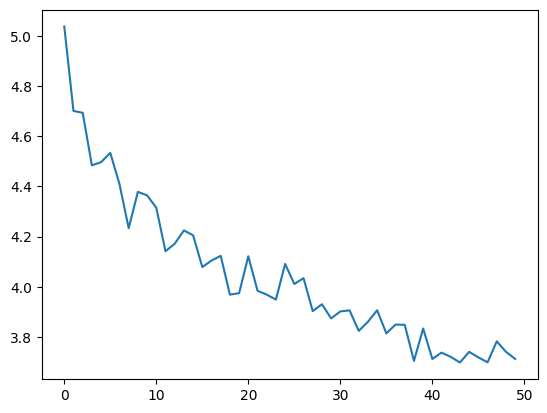

In [46]:
print_every=1000
plot_every=500
learning_rate=0.01
n_iters=25000

trainIters(encoder1, attn_decoder1, n_iters=n_iters, plot_every=plot_every, print_every=print_every)

In [49]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = torch.zeros(1, 1, 128, device=device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [51]:
sen = "Il faut que tu reviennes"
# We need you back.	Il faut que tu reviennes
de, de_att = evaluate(encoder1, attn_decoder1, sen.lower())
print(" ".join(de[:-1]))

it s you want to


In [52]:
# Still bad bro :/

In [53]:
path = "C:/Users/siddp/OneDrive/Desktop/project/encoder-decoder-models/model"
# torch.save(encoder1.state_dict(), path + "/encoder_simple.pth")
torch.save(attn_decoder1.state_dict(), path + "/decoder_attention.pth")